# Training a neural network with McSnow autoconversion output

This script applies a DNN to the regression problem to find Phi_au(tau) of Seifert and Beheng (2001)

Here it is tested with a Log transform of data and predictors is helpful. In short: it is!

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


### Load data from netcdf

In [2]:
import numpy as np
import xarray as xr

In [3]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

#data='small'
data='big'

# small dataset with selected parameter range, e.g. starting at 11 mu radius and nu=0,1,2, and only 2 independent realizations
fname1=mdir+edir+'autocon_train_'+data+'.nc'
fname2=mdir+edir+'autocon_test_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 6, ii: 6, j: 7, jj: 7, k: 5, kk: 5, n: 5, nn: 5, nt: 4000)
Coordinates:
  * n           (n) int32 0 1 2 3 4
  * i           (i) int32 200 400 600 800 1000 2000
  * j           (j) int32 9 10 11 12 13 14 15
  * k           (k) int32 0 1 2 3 4
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n

# Prepare data for training

In [4]:
def read_and_prepare_data(fname,auto_sml):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    auto = xr.open_dataset(fname).auto_mass.values
    accr = xr.open_dataset(fname).accr_mass.values
    selfr = xr.open_dataset(fname).self_rain.values
    selfc = xr.open_dataset(fname).self_cloud.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    Nr   = xr.open_dataset(fname).Nr.values
    nu   = xr.open_dataset(fname).nu.values
    # some numerical lower bounds
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    auto_min = 1e-15
    # introduce small but non-zero value for autoconversion into the dataset
    # (this can maybe called "data augmentation", because in that way we keep more data by adding artificial "labels")
    if auto_sml > 0:
        if (auto_sml < 1):
            # small but constant value
            auto = np.where( (Lc > 1e-5) & (auto < auto_sml) & (tau < 0.1),auto_sml,auto)
        else:
            # use autoconversion based on Long kernel. This gives our augmented data the proper scaling
            kcc = 9.44e9     # Long kernel in m3 kg-2 s-1 
            xstar = 2.6e-10    # xstar in kg
            auLg = kcc/(20*xstar) * (nu+2.0)*(nu+4.0)/(nu+1.0)**2 * Lc**2 * (Lc/(Nc+N_min))**2
            auto = np.where( (Lc > 1e-5) & (auto < auLg) & (tau < 0.1),auLg,auto)
    # take out L**2 dependency
    autoL2 = auto * np.power(Lc,-2)
    # transform everything except nu in log space
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Xr = np.log(Lr/Nr, where=Nr>N_min)
    Nc = np.log(Nc, where=Nc>N_min)
    Nr = np.log(Nr, where=Nr>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau  = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    auto = np.log(auto, where=auto>auto_min, out=np.nan*auto)
    accr = np.log(accr, where=accr>auto_min, out=np.nan*accr)
    selfr = np.log(selfr, where=selfr>auto_min, out=np.nan*selfr)
    selfc = np.log(selfc, where=selfc>auto_min, out=np.nan*selfc)
    autoL2 = np.log(autoL2, where=autoL2>auto_min, out=np.nan*autoL2)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ auto.ravel(), accr.ravel(), selfc.ravel(), selfr.ravel(), Lc.ravel(), Xc.ravel(), Nc.ravel(), Lr.ravel(), Xr.ravel(), Nr.ravel(), nu.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['auto','accr','selfc','selfr','Lc','Xc','Nc','Lr','Xr','Nr','nu'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [5]:
# introduce small but non-zero value for autoconversion if AUsml > 0, Long-Value for AUsml=1#
AUsml=1e-11
#AUsml=0

dataset_train = read_and_prepare_data(fname1,AUsml)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python

In [6]:
dataset_test = read_and_prepare_data(fname2,0)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/pyt

### Inspect the data

In [7]:
dataset_train.head()

auto       accr     selfc      selfr        Lc         Xc  \
344 -23.952938 -24.457457  6.583181 -15.162584 -8.522467 -26.460238   
348 -25.328436 -23.431816  5.297692 -15.648092 -8.522487 -26.459875   
349 -25.140886 -24.031610  6.458368 -14.360238 -8.522492 -26.459671   
353 -25.328436 -23.905104  4.918695 -17.727533 -8.522512 -26.459257   
354 -25.328436 -23.727608  6.662805 -10.206758 -8.522517 -26.459005   

            Nc         Lr         Xr        Nr   nu  
344  17.937771 -16.649040 -21.313763  4.664721  0.0  
348  17.937387 -16.577154 -21.253649  4.676495  0.0  
349  17.937178 -16.561876 -21.246902  4.685025  0.0  
353  17.936745 -16.505926 -21.208977  4.703050  0.0  
354  17.936489 -16.488857 -21.197927  4.709071  0.0

In [8]:
dataset_test.head()

auto       accr     selfc      selfr        Lc         Xc  \
209 -24.985968 -23.796324  7.477921 -13.815511 -8.116768 -26.458797   
233 -24.222260 -23.128084  7.443570 -14.837162 -8.116875 -26.452421   
236 -25.340450 -23.070887  7.092939 -16.341240 -8.116895 -26.451477   
237 -23.806532 -22.871672  6.968399 -15.088476 -8.116904 -26.451252   
244 -22.902794 -23.281197  7.170158 -14.731801 -8.117008 -26.449501   

            Nc         Lr         Xr        Nr   nu  
209  18.342030 -17.093740 -21.669786  4.576045  0.0  
233  18.335546 -16.476637 -21.376474  4.899838  0.0  
236  18.334583 -16.391291 -21.328222  4.936931  0.0  
237  18.334347 -16.349474 -21.311150  4.961676  0.0  
244  18.332493 -16.019880 -21.371468  5.351588  0.0

In [9]:
dataset_train.describe()

auto           accr          selfc          selfr  \
count  171616.000000  171616.000000  171616.000000  171616.000000   
mean      -21.971277     -17.185585       6.136833      -1.696541   
std         3.260669       2.284526       2.511158       5.764553   
min       -34.531921     -27.579996     -14.293547     -17.727533   
25%       -24.345131     -18.670841       4.930533      -4.227073   
50%       -21.641931     -16.979711       6.447880       0.159066   
75%       -19.508049     -15.476004       7.887472       2.339515   
max       -13.795737     -11.982386      11.287971       8.206409   

                  Lc             Xc             Nc             Lr  \
count  171616.000000  171616.000000  171616.000000  171616.000000   
mean       -8.388984     -25.779787      17.393763     -10.333520   
std         1.128446       0.524753       1.163358       2.446105   
min       -15.244216     -28.867392      11.050814     -20.693756   
25%        -8.837322     -26.152203      16.697044     -12.190740   
50%        -8.519912     -25.827845      17.496208      -9.930911   
75%        -7.547418     -25.346622      18.196556      -8.272651   
max        -6.215789     -24.881920      20.245541      -6.216660   

                  Xr             Nr             nu  
count  171616.000000  171616.000000  171616.000000  
mean      -18.758955       8.425329       1.985782  
std         2.260366       1.668433       1.398449  
min       -22.034079       0.919470       0.000000  
25%       -20.629087       7.315413       1.000000  
50%       -19.270785       8.456190       2.000000  
75%       -17.286889       9.619744       3.000000  
max        -9.988203      13.366846       4.000000

In [10]:
dataset_test.describe()

auto           accr          selfc          selfr  \
count  115597.000000  115597.000000  115597.000000  115597.000000   
mean      -21.271860     -16.734436       6.432274      -0.879374   
std         3.134353       2.141019       2.536291       5.632350   
min       -34.522449     -26.092051     -15.424949     -17.727533   
25%       -23.151060     -18.077759       5.508862      -2.953750   
50%       -20.751066     -16.325657       6.942533       1.087406   
75%       -18.941679     -15.142465       8.103939       2.957833   
max       -14.251979     -12.556507      10.798604       7.631461   

                  Lc             Xc             Nc             Lr  \
count  115597.000000  115597.000000  115597.000000  115597.000000   
mean       -8.272609     -25.671133      17.402531     -10.016960   
std         1.175716       0.480451       1.184953       2.415925   
min       -15.107750     -28.958502      11.222438     -19.114672   
25%        -8.735324     -26.096029      16.785381     -11.834079   
50%        -8.119697     -25.625368      17.557926      -9.441428   
75%        -7.516638     -25.332548      18.217360      -8.022125   
max        -6.503471     -24.882051      19.962086      -6.504292   

                  Xr             Nr             nu  
count  115597.000000  115597.000000  115597.000000  
mean      -18.815422       8.798325       2.009871  
std         2.290565       1.589830       1.399014  
min       -22.001692       1.989081       0.000000  
25%       -20.732119       7.741759       1.000000  
50%       -19.361036       8.865338       2.000000  
75%       -17.276079       9.967082       3.000000  
max        -9.846516      13.045459       4.000000

### Further reduce data to relevant parameter range for autoconversion

In [11]:
def reduce_data(dataset):
#    idx = dataset[ dataset['tau'] > np.log(0.85) ].index
#    dataset.drop(idx,inplace=True)
    idx = dataset[ dataset['Lc'] < np.log(1e-9) ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [12]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)

In [13]:
dataset_train.describe()

auto           accr          selfc          selfr  \
count  171616.000000  171616.000000  171616.000000  171616.000000   
mean      -21.971277     -17.185585       6.136833      -1.696541   
std         3.260669       2.284526       2.511158       5.764553   
min       -34.531921     -27.579996     -14.293547     -17.727533   
25%       -24.345131     -18.670841       4.930533      -4.227073   
50%       -21.641931     -16.979711       6.447880       0.159066   
75%       -19.508049     -15.476004       7.887472       2.339515   
max       -13.795737     -11.982386      11.287971       8.206409   

                  Lc             Xc             Nc             Lr  \
count  171616.000000  171616.000000  171616.000000  171616.000000   
mean       -8.388984     -25.779787      17.393763     -10.333520   
std         1.128446       0.524753       1.163358       2.446105   
min       -15.244216     -28.867392      11.050814     -20.693756   
25%        -8.837322     -26.152203      16.697044     -12.190740   
50%        -8.519912     -25.827845      17.496208      -9.930911   
75%        -7.547418     -25.346622      18.196556      -8.272651   
max        -6.215789     -24.881920      20.245541      -6.216660   

                  Xr             Nr             nu  
count  171616.000000  171616.000000  171616.000000  
mean      -18.758955       8.425329       1.985782  
std         2.260366       1.668433       1.398449  
min       -22.034079       0.919470       0.000000  
25%       -20.629087       7.315413       1.000000  
50%       -19.270785       8.456190       2.000000  
75%       -17.286889       9.619744       3.000000  
max        -9.988203      13.366846       4.000000

In [14]:
dataset_test.describe()

auto           accr          selfc          selfr  \
count  115597.000000  115597.000000  115597.000000  115597.000000   
mean      -21.271860     -16.734436       6.432274      -0.879374   
std         3.134353       2.141019       2.536291       5.632350   
min       -34.522449     -26.092051     -15.424949     -17.727533   
25%       -23.151060     -18.077759       5.508862      -2.953750   
50%       -20.751066     -16.325657       6.942533       1.087406   
75%       -18.941679     -15.142465       8.103939       2.957833   
max       -14.251979     -12.556507      10.798604       7.631461   

                  Lc             Xc             Nc             Lr  \
count  115597.000000  115597.000000  115597.000000  115597.000000   
mean       -8.272609     -25.671133      17.402531     -10.016960   
std         1.175716       0.480451       1.184953       2.415925   
min       -15.107750     -28.958502      11.222438     -19.114672   
25%        -8.735324     -26.096029      16.785381     -11.834079   
50%        -8.119697     -25.625368      17.557926      -9.441428   
75%        -7.516638     -25.332548      18.217360      -8.022125   
max        -6.503471     -24.882051      19.962086      -6.504292   

                  Xr             Nr             nu  
count  115597.000000  115597.000000  115597.000000  
mean      -18.815422       8.798325       2.009871  
std         2.290565       1.589830       1.399014  
min       -22.001692       1.989081       0.000000  
25%       -20.732119       7.741759       1.000000  
50%       -19.361036       8.865338       2.000000  
75%       -17.276079       9.967082       3.000000  
max        -9.846516      13.045459       4.000000

### Pairplot

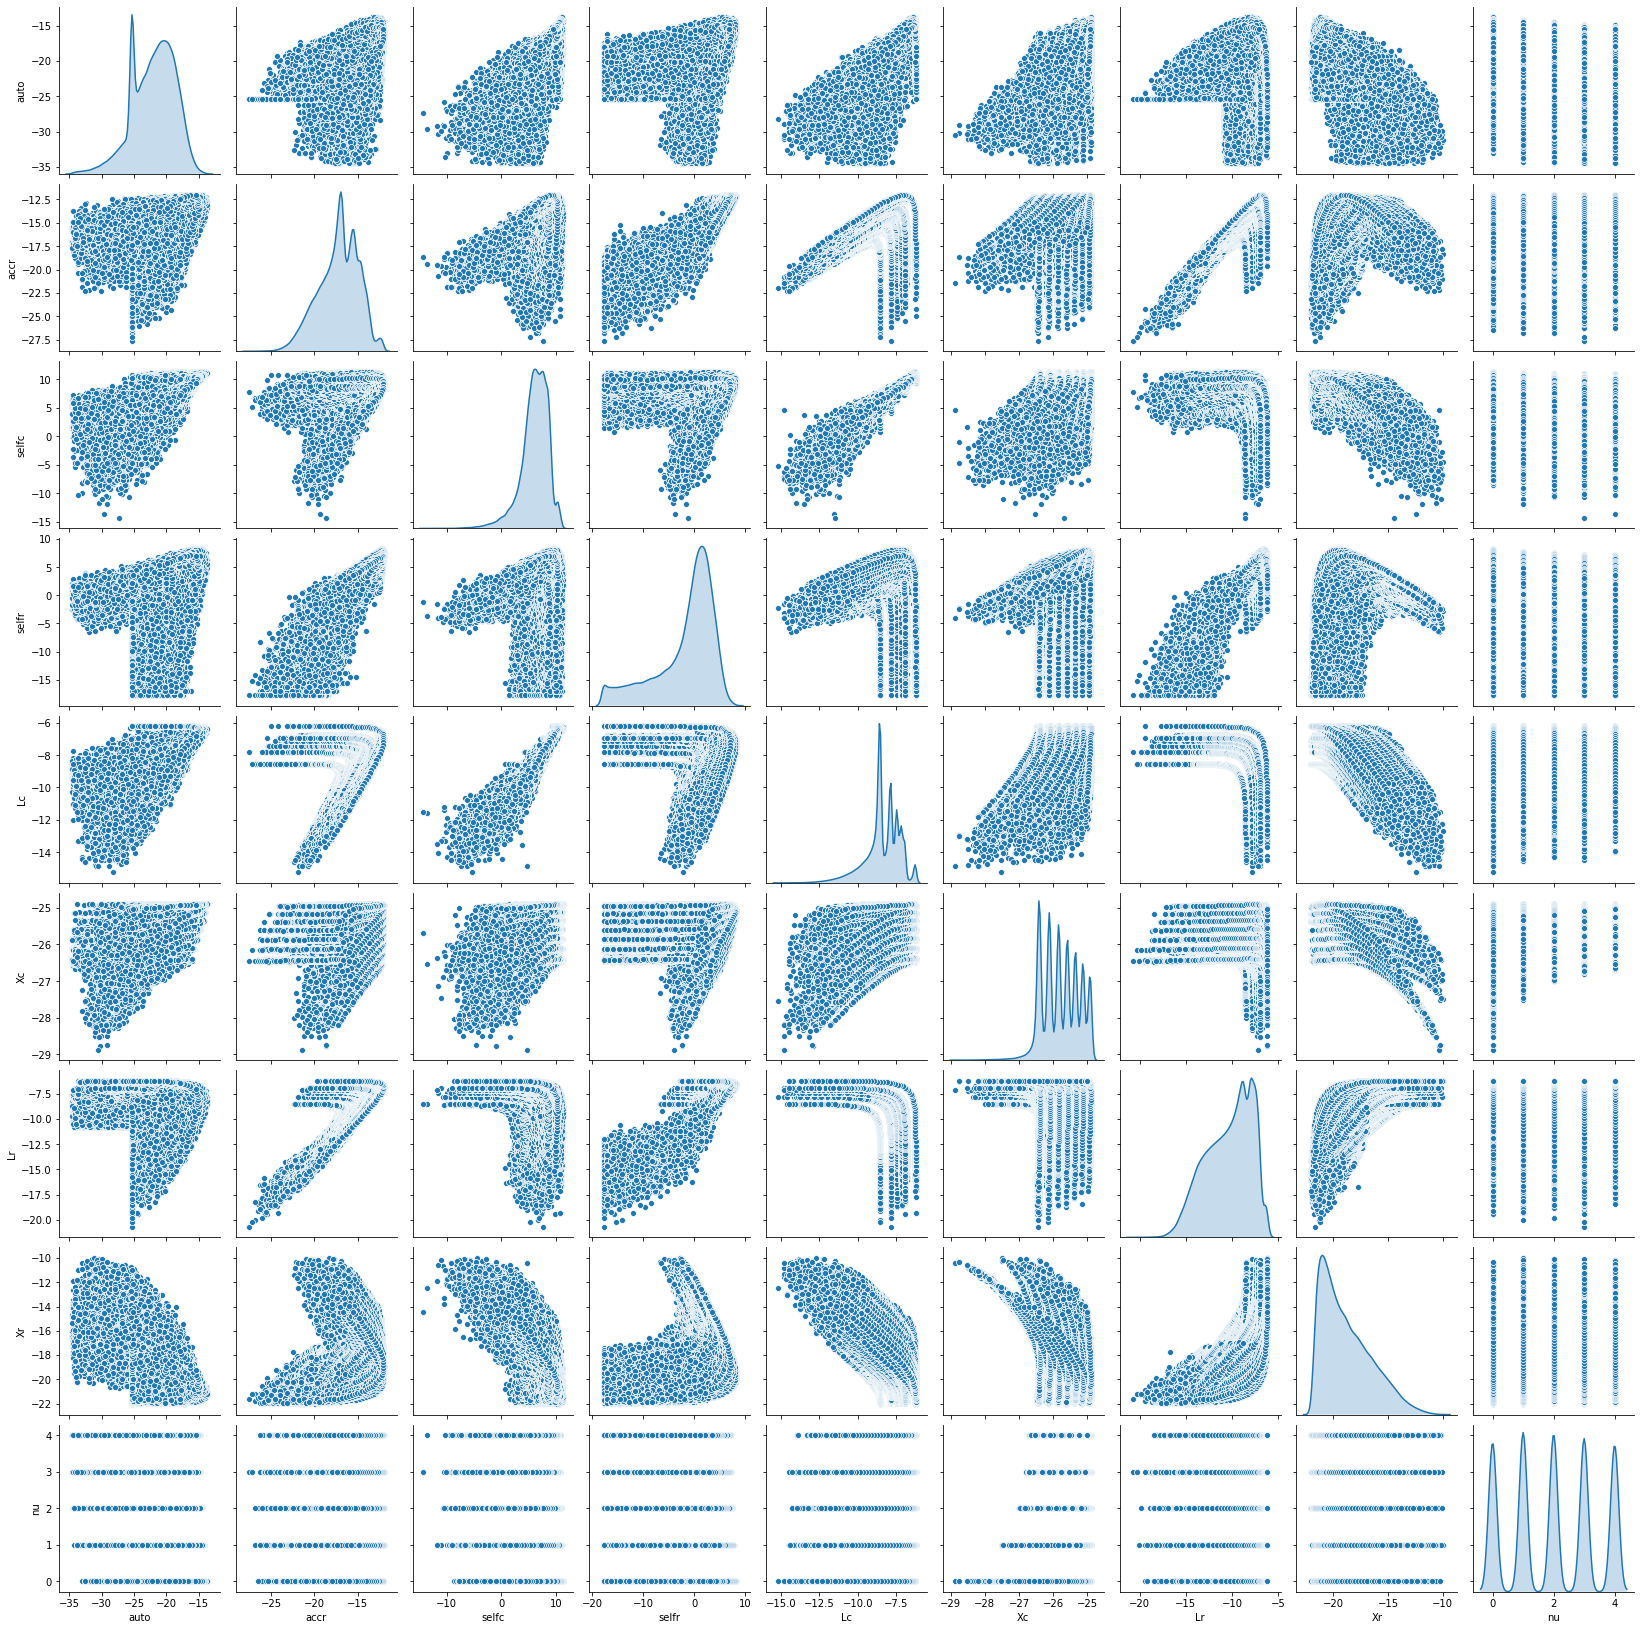

In [15]:
sns.pairplot(dataset_train[["auto","accr","selfc","selfr","Lc","Xc","Lr","Xr",'nu']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [16]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [17]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [18]:
train_dataset1 = train_dataset1.drop(['Nc','Nr'], axis=1)
train_dataset2 = train_dataset2.drop(['Xc','Xr'], axis=1)
train_dataset3 = train_dataset3.drop(['Lc','Lr'], axis=1)

In [19]:
test_dataset1 = test_dataset1.drop(['Nc','Nr'], axis=1)
test_dataset2 = test_dataset2.drop(['Xc','Xr'], axis=1)
test_dataset3 = test_dataset3.drop(['Lc','Lr'], axis=1)

In [20]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("auto")
train_stats1.pop("accr")
train_stats1.pop("selfc")
train_stats1.pop("selfr")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lc  171616.0  -8.388984  1.128446 -15.244216  -8.837322  -8.519912  -7.547418   
Xc  171616.0 -25.779787  0.524753 -28.867392 -26.152203 -25.827845 -25.346622   
Lr  171616.0 -10.333520  2.446105 -20.693756 -12.190740  -9.930911  -8.272651   
Xr  171616.0 -18.758955  2.260366 -22.034079 -20.629087 -19.270785 -17.286889   
nu  171616.0   1.985782  1.398449   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215789  
Xc -24.881920  
Lr  -6.216660  
Xr  -9.988203  
nu   4.000000

In [21]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("auto")
train_stats2.pop("accr")
train_stats2.pop("selfc")
train_stats2.pop("selfr")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  171616.0  -8.388984  1.128446 -15.244216  -8.837322  -8.519912  -7.547418   
Nc  171616.0  17.393763  1.163358  11.050814  16.697044  17.496208  18.196556   
Lr  171616.0 -10.333520  2.446105 -20.693756 -12.190740  -9.930911  -8.272651   
Nr  171616.0   8.425329  1.668433   0.919470   7.315413   8.456190   9.619744   
nu  171616.0   1.985782  1.398449   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215789  
Nc  20.245541  
Lr  -6.216660  
Nr  13.366846  
nu   4.000000

In [22]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("auto")
train_stats3.pop("accr")
train_stats3.pop("selfc")
train_stats3.pop("selfr")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%        75%  \
Xc  171616.0 -25.779787  0.524753 -28.867392 -26.152203 -25.827845 -25.346622   
Nc  171616.0  17.393763  1.163358  11.050814  16.697044  17.496208  18.196556   
Xr  171616.0 -18.758955  2.260366 -22.034079 -20.629087 -19.270785 -17.286889   
Nr  171616.0   8.425329  1.668433   0.919470   7.315413   8.456190   9.619744   
nu  171616.0   1.985782  1.398449   0.000000   1.000000   2.000000   3.000000   

          max  
Xc -24.881920  
Nc  20.245541  
Xr  -9.988203  
Nr  13.366846  
nu   4.000000

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [23]:
# pop does not work for multiply columns, use copy instead

train_labels1 = train_dataset1[['auto','accr','selfc','selfr']].copy()
train_dataset1.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

test_labels1 = test_dataset1[['auto','accr','selfc','selfr']].copy()
test_dataset1.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

In [24]:
train_labels2 = train_dataset2[['auto','accr','selfc','selfr']].copy()
train_dataset2.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

test_labels2 = test_dataset2[['auto','accr','selfc','selfr']].copy()
test_dataset2.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

In [25]:
train_labels3 = train_dataset3[['auto','accr','selfc','selfr']].copy()
train_dataset3.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

test_labels3 = test_dataset3[['auto','accr','selfc','selfr']].copy()
test_dataset3.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

In [26]:
train_labels1.describe()

auto           accr          selfc          selfr
count  171616.000000  171616.000000  171616.000000  171616.000000
mean      -21.971277     -17.185585       6.136833      -1.696541
std         3.260669       2.284526       2.511158       5.764553
min       -34.531921     -27.579996     -14.293547     -17.727533
25%       -24.345131     -18.670841       4.930533      -4.227073
50%       -21.641931     -16.979711       6.447880       0.159066
75%       -19.508049     -15.476004       7.887472       2.339515
max       -13.795737     -11.982386      11.287971       8.206409

In [27]:
train_dataset1.describe()

Lc             Xc             Lr             Xr  \
count  171616.000000  171616.000000  171616.000000  171616.000000   
mean       -8.388984     -25.779787     -10.333520     -18.758955   
std         1.128446       0.524753       2.446105       2.260366   
min       -15.244216     -28.867392     -20.693756     -22.034079   
25%        -8.837322     -26.152203     -12.190740     -20.629087   
50%        -8.519912     -25.827845      -9.930911     -19.270785   
75%        -7.547418     -25.346622      -8.272651     -17.286889   
max        -6.215789     -24.881920      -6.216660      -9.988203   

                  nu  
count  171616.000000  
mean        1.985782  
std         1.398449  
min         0.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         4.000000

In [28]:
train_labels2.describe()

auto           accr          selfc          selfr
count  171616.000000  171616.000000  171616.000000  171616.000000
mean      -21.971277     -17.185585       6.136833      -1.696541
std         3.260669       2.284526       2.511158       5.764553
min       -34.531921     -27.579996     -14.293547     -17.727533
25%       -24.345131     -18.670841       4.930533      -4.227073
50%       -21.641931     -16.979711       6.447880       0.159066
75%       -19.508049     -15.476004       7.887472       2.339515
max       -13.795737     -11.982386      11.287971       8.206409

In [29]:
train_dataset2.describe()

Lc             Nc             Lr             Nr  \
count  171616.000000  171616.000000  171616.000000  171616.000000   
mean       -8.388984      17.393763     -10.333520       8.425329   
std         1.128446       1.163358       2.446105       1.668433   
min       -15.244216      11.050814     -20.693756       0.919470   
25%        -8.837322      16.697044     -12.190740       7.315413   
50%        -8.519912      17.496208      -9.930911       8.456190   
75%        -7.547418      18.196556      -8.272651       9.619744   
max        -6.215789      20.245541      -6.216660      13.366846   

                  nu  
count  171616.000000  
mean        1.985782  
std         1.398449  
min         0.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         4.000000

In [30]:
train_dataset3.describe()

Xc             Nc             Xr             Nr  \
count  171616.000000  171616.000000  171616.000000  171616.000000   
mean      -25.779787      17.393763     -18.758955       8.425329   
std         0.524753       1.163358       2.260366       1.668433   
min       -28.867392      11.050814     -22.034079       0.919470   
25%       -26.152203      16.697044     -20.629087       7.315413   
50%       -25.827845      17.496208     -19.270785       8.456190   
75%       -25.346622      18.196556     -17.286889       9.619744   
max       -24.881920      20.245541      -9.988203      13.366846   

                  nu  
count  171616.000000  
mean        1.985782  
std         1.398449  
min         0.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         4.000000

### Normalize the data

In [31]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

In [32]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean       std       min       25%       50%       75%  \
Lc  171616.0 -1.181642e-03  1.000052 -6.074930 -0.397306 -0.116025  0.745774   
Xc  171616.0 -6.818632e-03  0.999969 -5.883924 -0.709698 -0.091581  0.825464   
Lr  171616.0 -1.004330e-05  1.000012 -4.235400 -0.759256  0.164592  0.842510   
Xr  171616.0  5.132846e-05  1.000013 -1.448935 -0.827358 -0.226437  0.651251   
nu  171616.0 -3.876746e-08  1.000049 -1.419989 -0.704911  0.010167  0.725245   

         max  
Lc  1.925829  
Xc  1.711029  
Lr  1.683026  
Xr  3.880236  
nu  1.440322

In [33]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean       std       min       25%       50%       75%  \
Lc  171616.0 -1.181642e-03  1.000052 -6.074930 -0.397306 -0.116025  0.745774   
Nc  171616.0 -6.142355e-04  1.000013 -5.452277 -0.598886  0.088060  0.690066   
Lr  171616.0 -1.004330e-05  1.000012 -4.235400 -0.759256  0.164592  0.842510   
Nr  171616.0 -2.081595e-05  1.000016 -4.498747 -0.665245  0.018497  0.715890   
nu  171616.0 -3.876746e-08  1.000049 -1.419989 -0.704911  0.010167  0.725245   

         max  
Lc  1.925829  
Nc  2.451333  
Lr  1.683026  
Nr  2.961770  
nu  1.440322

In [34]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Xc  171616.0 -6.818632e-03  0.999969 -5.883924 -0.709698 -0.091581  0.825464   
Nc  171616.0 -6.142355e-04  1.000013 -5.452277 -0.598886  0.088060  0.690066   
Xr  171616.0  5.132846e-05  1.000013 -1.448935 -0.827358 -0.226437  0.651251   
Nr  171616.0 -2.081595e-05  1.000016 -4.498747 -0.665245  0.018497  0.715890   
nu  171616.0 -3.876746e-08  1.000049 -1.419989 -0.704911  0.010167  0.725245   

         max  
Xc  1.711029  
Nc  2.451333  
Xr  3.880236  
Nr  2.961770  
nu  1.440322

# The model

## Build the model

In [35]:

netString = "32x32x32"

def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='tanh', input_shape=[ncol]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='tanh', input_shape=[ncol]),
    layers.Dense(32, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(32, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[ncol]),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, input_shape=[ncol]),
    layers.Dense(32, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(32, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, input_shape=[ncol]),
    layers.Dense(32, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(32, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[ncol]),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[ncol]),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [36]:
    
#activ = "PReLU"
#activ = "LReLU"
activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(5,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 2,436
Trainable params: 2,436
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [38]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.725786  , -0.13828328,  0.50302297,  0.9734267 ],
       [ 0.7214924 , -0.13521108,  0.5013332 ,  0.9715337 ],
       [ 0.72076035, -0.13467687,  0.50089407,  0.97111773],
       [ 0.7176589 , -0.13244492,  0.49940795,  0.96958184],
       [ 0.71671283, -0.13174042,  0.4989617 ,  0.9691314 ],
       [ 0.7130965 , -0.12912127,  0.4974315 ,  0.9674884 ],
       [ 0.70598155, -0.12409815,  0.49133128,  0.96195924],
       [ 0.70011795, -0.11975402,  0.48615265,  0.95726264],
       [ 0.6956786 , -0.11650261,  0.48343736,  0.954571  ],
       [ 0.6934907 , -0.11472753,  0.48123032,  0.9526174 ]],
      dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [39]:
# maximum number, but we use early stopping
EPOCHS = 100

# part of training data that is used for validation during training
VALSPLIT = 0.3

# learning rate
learn = 1e-3        # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [40]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:12.8045,  mae:1.7689,  mse:12.8045,  val_loss:1.5642,  val_mae:0.7404,  val_mse:1.5642,  
..............................

Text(0, 0.5, 'MAE')

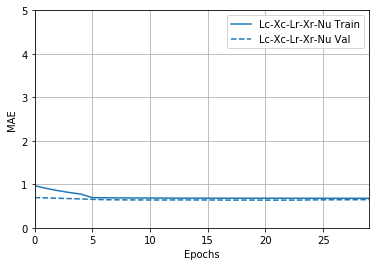

In [41]:
histories['Lc-Xc-Lr-Xr-nu'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [42]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:11.1160,  mae:1.6371,  mse:11.1160,  val_loss:1.5147,  val_mae:0.7061,  val_mse:1.5147,  
......................................

Text(0, 0.5, 'MAE')

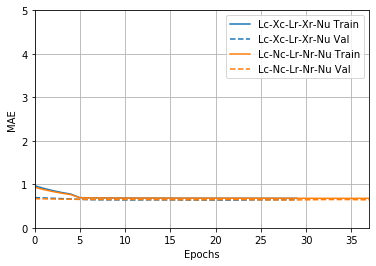

In [43]:
histories['Lc-Nc-Lr-nr-nu'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [44]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:10.8813,  mae:1.5759,  mse:10.8813,  val_loss:1.4205,  val_mae:0.6739,  val_mse:1.4205,  
......................

Text(0, 0.5, 'MAE')

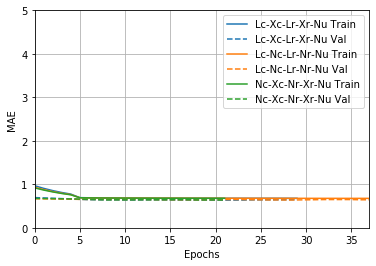

In [45]:
histories['Nc-Xc-Nr-Xr-nu'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE of AU')

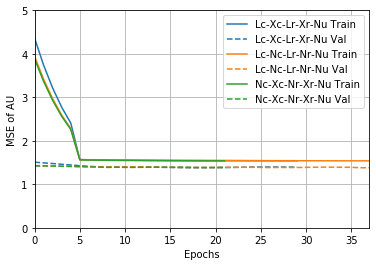

In [46]:
plotter.plot(histories, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('MSE of AU')

In [47]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

115597/115597 - 2s - loss: 1.2915 - mae: 0.6004 - mse: 1.2915
Testing set for model 1, Mean Abs Error:    0.60038


In [48]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

115597/115597 - 2s - loss: 1.2890 - mae: 0.6049 - mse: 1.2890
Testing set for model 2, Mean Abs Error:              0.60488


In [49]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:30.5f}".format(mae3))

115597/115597 - 2s - loss: 1.3013 - mae: 0.6117 - mse: 1.3013
Testing set for model 3, Mean Abs Error:                        0.61169


# Make predictions

Finally, predict the fall velocity values using data in the testing set:

In [50]:
model1.predict(normed_test_data1)

array([[-24.728693 , -23.986889 ,   6.353568 , -15.930808 ],
       [-24.489721 , -23.385841 ,   6.502582 , -15.384555 ],
       [-24.462444 , -23.284302 ,   6.521099 , -15.280095 ],
       ...,
       [-23.732708 , -15.007776 ,   2.794677 ,   3.7492495],
       [-24.005623 , -15.189701 ,   2.4689748,   3.5355058],
       [-24.260696 , -15.374145 ,   2.1443002,   3.3229723]],
      dtype=float32)

In [51]:
type(test_labels1)

pandas.core.frame.DataFrame

In [52]:
test_true_au = np.exp(test_labels1.pop('auto'))
test_true_ac = np.exp(test_labels1.pop('accr'))

test_true_sc_cloud = np.exp(test_labels1.pop('selfc'))
test_true_sc_rain  = np.exp(test_labels1.pop('selfr'))


In [53]:
test_predict1 = np.exp(model1.predict(normed_test_data1))
type(test_predict1)

numpy.ndarray

In [54]:
test_predict1_au = test_predict1[:,0]
test_predict1_ac = test_predict1[:,1]

test_predict1_sc_cloud = test_predict1[:,2]
test_predict1_sc_rain  = test_predict1[:,3]


In [55]:
test_predict2 = np.exp(model2.predict(normed_test_data2))

test_predict2_au = test_predict2[:,0]
test_predict2_ac = test_predict2[:,1]

test_predict2_sc_cloud = test_predict2[:,2]
test_predict2_sc_rain  = test_predict2[:,3]

In [56]:
test_predict3 = np.exp(model3.predict(normed_test_data3))

test_predict3_au = test_predict3[:,0]
test_predict3_ac = test_predict3[:,1]

test_predict3_sc_cloud = test_predict3[:,2]
test_predict3_sc_rain  = test_predict3[:,3]

In [57]:
len(test_true_au)

115597

In [58]:
test_predict1_au

array([1.8216506e-11, 2.3133917e-11, 2.3773625e-11, ..., 4.9319184e-11,
       3.7539669e-11, 2.9087970e-11], dtype=float32)

In [59]:
test_true_au

209        1.408420e-11
233        3.022779e-11
236        9.880576e-12
237        4.580939e-11
244        1.130949e-10
               ...     
3496068    7.388835e-10
3496069    7.771175e-10
3496070    1.058209e-10
3496071    1.616720e-12
3496072    2.001218e-11
Name: auto, Length: 115597, dtype: float32

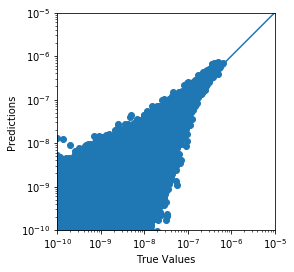

In [60]:
amin, amax = 1e-10, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_true_au, test_predict1_au)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

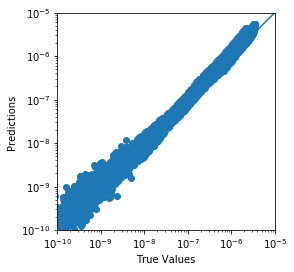

In [61]:
amin, amax = 1e-10, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_true_ac, test_predict1_ac)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

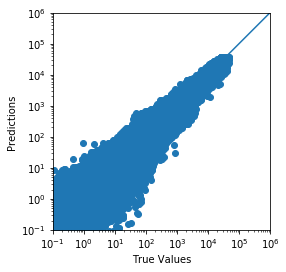

In [62]:
amin, amax = 1e-1, 1e6

a = plt.axes(aspect='equal')
plt.scatter(test_true_sc_cloud, test_predict1_sc_cloud)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

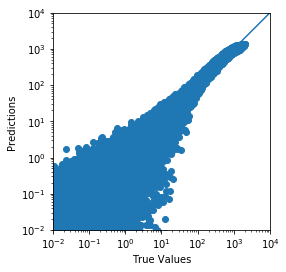

In [63]:
amin, amax = 1e-2, 1e4

a = plt.axes(aspect='equal')
plt.scatter(test_true_sc_rain, test_predict1_sc_rain)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [64]:
test_dataset1.describe()

Lc             Xc             Lr             Xr  \
count  115597.000000  115597.000000  115597.000000  115597.000000   
mean       -8.272609     -25.671133     -10.016960     -18.815422   
std         1.175716       0.480451       2.415925       2.290565   
min       -15.107750     -28.958502     -19.114672     -22.001692   
25%        -8.735324     -26.096029     -11.834079     -20.732119   
50%        -8.119697     -25.625368      -9.441428     -19.361036   
75%        -7.516638     -25.332548      -8.022125     -17.276079   
max        -6.503471     -24.882051      -6.504292      -9.846516   

                  nu  
count  115597.000000  
mean        2.009871  
std         1.399014  
min         0.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         4.000000

In [65]:
qc  = np.exp(np.array(test_dataset1.Lc))
qr  = np.exp(np.array(test_dataset1.Lr))
xc  = np.exp(np.array(test_dataset1.Xc))
xr  = np.exp(np.array(test_dataset1.Xr))

nue = np.array(test_dataset1.nu)

tau2 = qr/(qc+qr+1e-15)

## SB2001 autoconversion rate, original and re-trained on current data

In [66]:
kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 
kcr = 5.78        # Long kernel in m3 kg-1 s-1 
xstar = 2.6e-10   # xstar in kg

# autoconversion

au = kcc/(20*xstar) * (nue+2.0)*(nue+4.0)/(nue+1.0)**2 * qc**2 * xc**2

a1 = 600.
p1 = 0.68
taup = np.power(tau2,p1)
phi1 = a1 * taup * (1.0 - taup)**3

a2 = 954.
p2 = 0.773
taup = np.power(tau2,p2)
phi2 = a2 * taup * (1.0 - taup)**3

test_predict_sb1_au = au * phi1
test_predict_sb2_au = au * phi2

# accretion

phi = (tau2 / (tau2 + 5e-4))**4

test_predict_sb_ac = kcr * qc * qr * phi

test_predict_sb_sc_cloud = kcc * (nue+2)/(nue+1) * qc*qc - 2/xstar * test_predict_sb2_au

test_predict_sb_sc_rain  = kcr * qr * qr / xr   # = kcr * qr * nr  

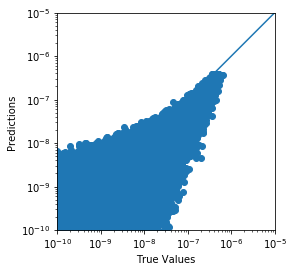

In [67]:
amin, amax = 1e-10, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_true_au, test_predict_sb1_au)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

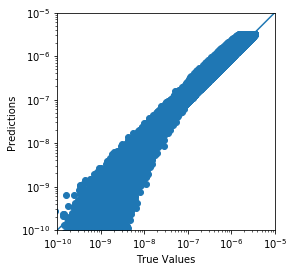

In [68]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_ac, test_predict_sb_ac)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

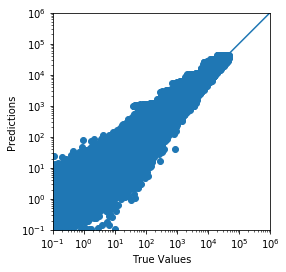

In [69]:
amin, amax = 1e-1, 1e6

a = plt.axes(aspect='equal')
plt.scatter(test_true_sc_cloud, test_predict_sb_sc_cloud)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

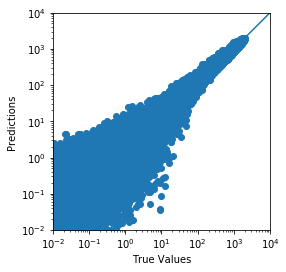

In [70]:
amin, amax = 1e-2, 1e4

a = plt.axes(aspect='equal')
plt.scatter(test_true_sc_rain, test_predict_sb_sc_rain)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Power law regression models

KK2000 and from notebook 'McSnow_autocon_powerlaws'

In [71]:
fac = 7.540743e+13 
a = 2.786325 
b = -1.620419 
c = -0.808443 

nc = qc/xc

test_predict_pwr_au = fac * np.power(qc,a) * np.power(nc,b) * np.power(nue+1,c)  

test_predict_kk_au  = 1350. * np.power(qc,2.47) * np.power(nc*1e-6,-1.79)  # Nc in CGS

# Here we use KK2000
fac = 6.7e1
a = 1.15
b = 1.15

# AU = fac * Lc**a * Nc**b * nu**c
test_predict_pwr_ac = fac * np.power(qc,a) * np.power(qr,b) 

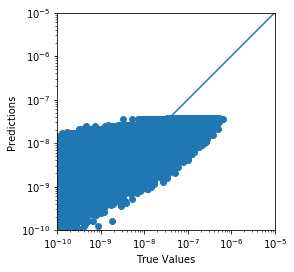

In [72]:
amin, amax = 1e-10, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_true_au, test_predict_kk_au)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

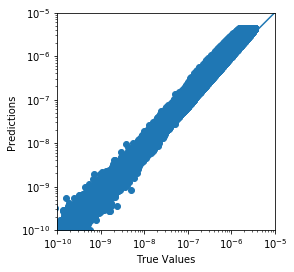

In [73]:

a = plt.axes(aspect='equal')
plt.scatter(test_true_ac, test_predict_pwr_ac)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Final statistics 

In [74]:
def mean_abs_error(au, auTrue):  
    return np.mean(np.abs(au - auTrue))

def mean_sqr_error(au, auTrue):    
    return np.sqrt(np.mean((au - auTrue)**2))                   

In [75]:
mae1 = mean_abs_error(test_predict1_au,test_true_au)
mae2 = mean_abs_error(test_predict2_au,test_true_au)
mae3 = mean_abs_error(test_predict3_au,test_true_au)

maeSB1 = mean_abs_error(test_predict_sb1_au,test_true_au)
maeSB2 = mean_abs_error(test_predict_sb2_au,test_true_au)
maeKK  = mean_abs_error(test_predict_kk_au, test_true_au)
maePwr = mean_abs_error(test_predict_pwr_au,test_true_au)

mse1 = mean_sqr_error(test_predict1_au,test_true_au)
mse2 = mean_sqr_error(test_predict2_au,test_true_au)
mse3 = mean_sqr_error(test_predict3_au,test_true_au)

mseSB1 = mean_sqr_error(test_predict_sb1_au,test_true_au)
mseSB2 = mean_sqr_error(test_predict_sb2_au,test_true_au)
mseKK  = mean_sqr_error(test_predict_kk_au, test_true_au)
msePwr = mean_sqr_error(test_predict_pwr_au,test_true_au)

mae = [ mae1, mae2, mae3, maeSB1, maeSB2, maeKK, maePwr ]
mse = [ mse1, mse2, mse3, mseSB1, mseSB2, mseKK, msePwr ]

In [76]:
mae

[3.0854334642782533e-09,
 3.0502820269617814e-09,
 3.6331440078640753e-09,
 4.546340193201104e-09,
 3.726986719243541e-09,
 7.142948454941234e-09,
 6.0516121003217904e-09]

In [77]:
labels = list(histories.keys())
labels.append('SB2001')
labels.append('SB new')
labels.append('KK2000')
labels.append('Power')
labels

['Lc-Xc-Lr-Xr-nu',
 'Lc-Nc-Lr-nr-nu',
 'Nc-Xc-Nr-Xr-nu',
 'SB2001',
 'SB new',
 'KK2000',
 'Power']

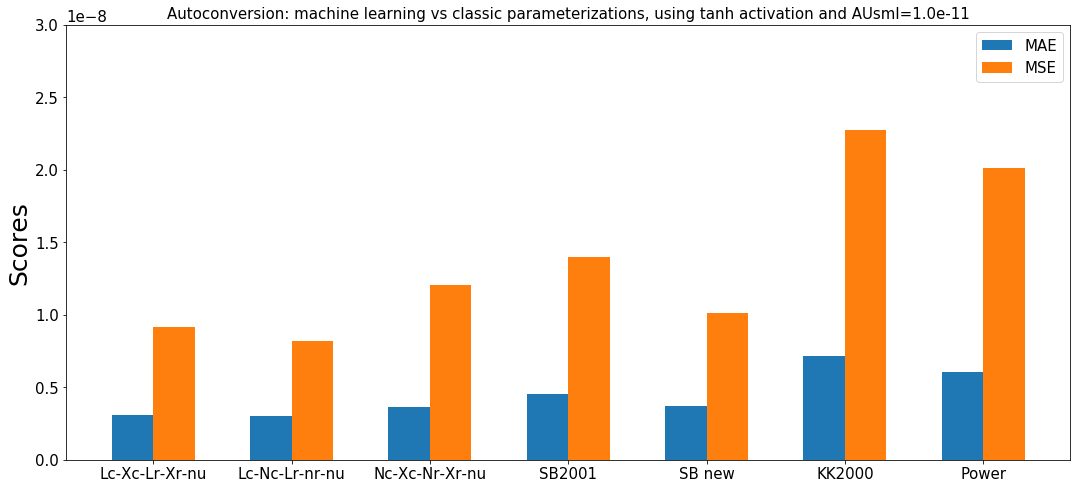

In [78]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Autoconversion: machine learning vs classic parameterizations, using '+activ+' activation and AUsml=%6.1e'%AUsml)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

In [79]:
mae1 = mean_abs_error(test_predict1_ac,test_true_ac)
mae2 = mean_abs_error(test_predict2_ac,test_true_ac)
mae3 = mean_abs_error(test_predict3_ac,test_true_ac)

maeSB1 = mean_abs_error(test_predict_sb_ac,test_true_ac)
maePwr = mean_abs_error(test_predict_pwr_ac,test_true_ac)

mse1 = mean_sqr_error(test_predict1_ac,test_true_ac)
mse2 = mean_sqr_error(test_predict2_ac,test_true_ac)
mse3 = mean_sqr_error(test_predict3_ac,test_true_ac)

mseSB1 = mean_sqr_error(test_predict_sb_ac,test_true_ac)
msePwr = mean_sqr_error(test_predict_pwr_ac,test_true_ac)

mae = [ mae1, mae2, mae3, maeSB1, maePwr ]
mse = [ mse1, mse2, mse3, mseSB1, msePwr ]

In [80]:
labels = list(histories.keys())
labels.append('SB2001')
labels.append('KK2000')
labels

['Lc-Xc-Lr-Xr-nu', 'Lc-Nc-Lr-nr-nu', 'Nc-Xc-Nr-Xr-nu', 'SB2001', 'KK2000']

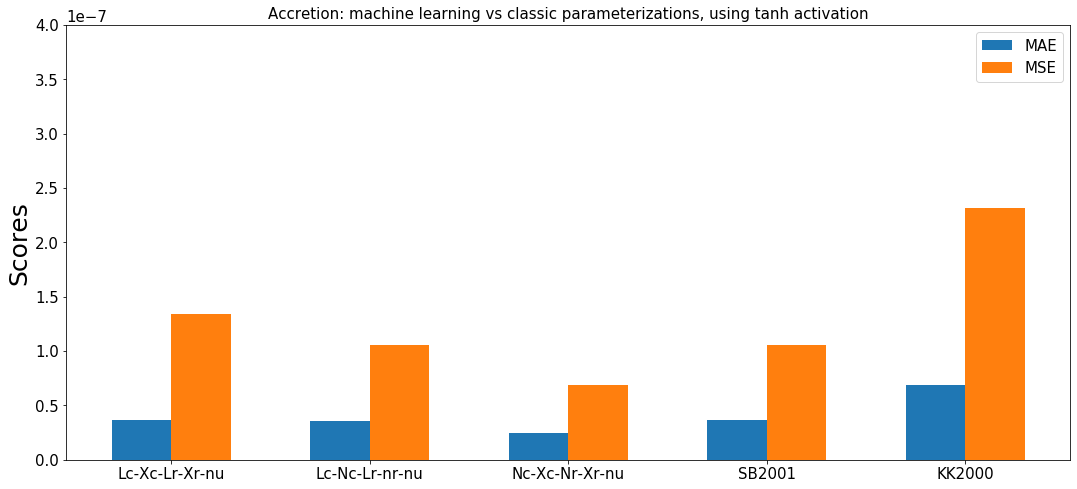

In [81]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Accretion: machine learning vs classic parameterizations, using '+activ+' activation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,4e-7)
ax.legend()

#fig.tight_layout()

plt.show()

# Save models to file

In [82]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model

if AUsml == 1:
    AUsmlString = '_AuLong'
elif AUsml > 0:
    AUsmlString = '_AUsml%5.0e'%AUsml
else:
    AUsmlString = ''
    
model1.save('saved_model/one4all_LcXcLrXrNu_v1_'+activ+AUsmlString+'_'+netString+'_'+data) 
model2.save('saved_model/one4all_LcNcLrNrNu_v1_'+activ+AUsmlString+'_'+netString+'_'+data) 
model3.save('saved_model/one4all_NcXcNrXrNu_v1_'+activ+AUsmlString+'_'+netString+'_'+data) 

# save train_stats for normalization of input data in Pandas pickle format
train_stats1.to_pickle('saved_model/one4all_LcXcLrXrNu_v1_'+activ+AUsmlString+'_'+netString+'_'+data+'_norm.pickle')
train_stats2.to_pickle('saved_model/one4all_LcNcLrNrNu_v1_'+activ+AUsmlString+'_'+netString+'_'+data+'_norm.pickle')
train_stats3.to_pickle('saved_model/one4all_NcXcNrXrNu_v1_'+activ+AUsmlString+'_'+netString+'_'+data+'_norm.pickle')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/one4all_LcXcLrXrNu_v1_tanh_AUsml1e-11_32x32x32_big/assets
INFO:tensorflow:Assets written to: saved_model/one4all_LcNcLrNrNu_v1_tanh_AUsml1e-11_32x32x32_big/assets
INFO:tensorflow:Assets written to: saved_model/one4all_NcXcNrXrNu_v1_tanh_AUsml1e-11_32x32x32_big/assets
